# Assignment 1: Labor Supply and Children

In [76]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Basic Model

In [89]:
# Initialize the basic model 
from DynLaborFertModel import DynLaborFertModelClass
basic_model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3}) # set spouse income and cost of children to zero for the basic model 

par = basic_model.par
sol = basic_model.sol
sim = basic_model.sim

### Solve and simulate the basic the model

In [90]:
%time basic_model.solve()
basic_model.simulate()

CPU times: total: 44.3 s
Wall time: 45.3 s


### Q1: Event-Study Graph 

What value of $\beta_1$ produces an event-study graph of working hours with something close to a drop in hours of 10% around the time of birth as in Kleven et. al. (2019, Fig. 1B):



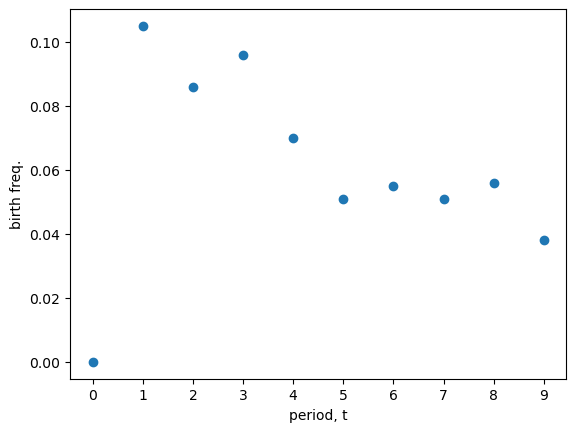

In [91]:
# Construct relative time variabel 

birth = np.zeros(sim.n.shape,dtype=np.int_)
birth[:,1:] = (sim.n[:,1:] - sim.n[:,:-1]) > 0
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(birth,axis=0))
ax.set(xlabel='period, t',ylabel=f'birth freq.',xticks=range(par.simT));

# time since birth
periods = np.tile([t for t in range(par.simT)],(par.simN,1))
time_of_birth = np.max(periods * birth, axis=1)

I = time_of_birth>0
time_of_birth[~I] = -1000 # never as a child
time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))

time_since_birth = periods - time_of_birth

# calculate average outcome across time since birth
min_time = -8
max_time = 8
event_grid = np.arange(min_time,max_time+1)

event_hours = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours[t] = np.mean(sim.h[time_since_birth==time])

# relative to period before birth
event_hours_rel = event_hours - event_hours[event_grid==-1]

Average difference in hours worked between period 0 and -1: -0.1449


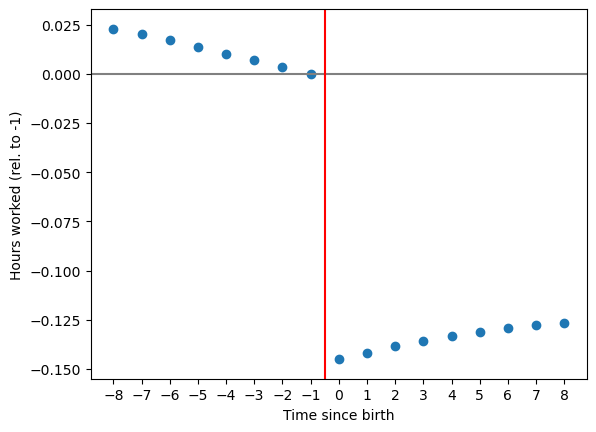

In [92]:
fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel)
ax.axhline(y=0,color='gray')
ax.axvline(x=-0.5,color='red')
ax.set(xlabel='Time since birth', 
       ylabel=f'Hours worked (rel. to -1)',
       xticks=event_grid,
       ylim=(min(event_hours_rel, default=0) - 0.01, max(event_hours_rel, default=0) + 0.01))

# Ensure -0.1 is included in y-axis
current_ymin, current_ymax = ax.get_ylim()
if current_ymin > -0.1:
    ax.set_ylim(bottom=-0.1, top=current_ymax)

# Calculate average difference between hours worked in period -1 and period 0
diff = np.mean(sim.h[time_since_birth==0]) - np.mean(sim.h[time_since_birth==-1])
print(f'Average difference in hours worked between period 0 and -1: {diff:.4f}')

### Q2: Introduce a spouse 

In [81]:
# Initialize the model implementing the spouse 
spouse_model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'zeta': 0.1}) # set spouse income and cost of children to zero for the basic model 

par = spouse_model.par
sol = spouse_model.sol
sim = spouse_model.sim

In [82]:
%time spouse_model.solve()

CPU times: total: 42.3 s
Wall time: 45.8 s


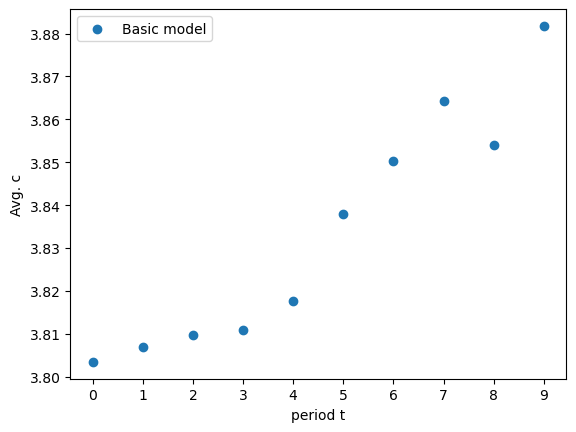

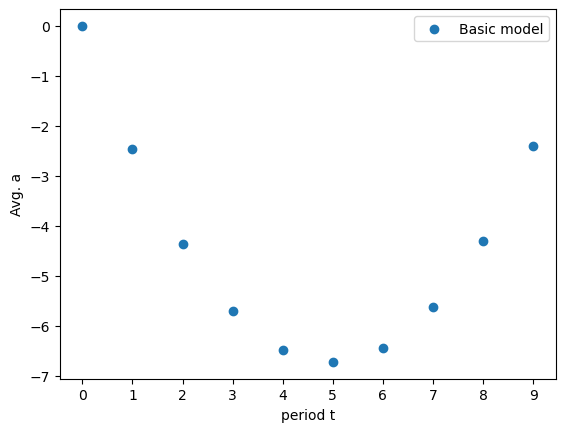

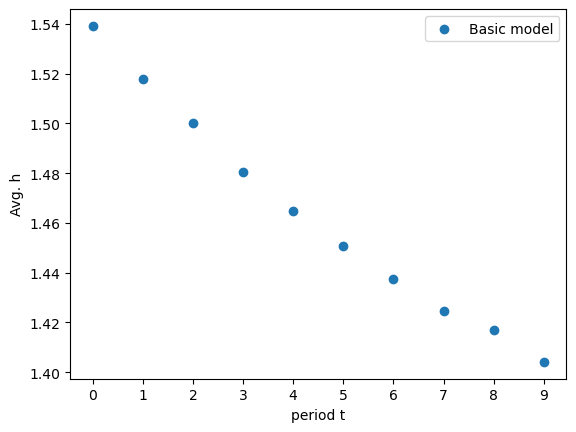

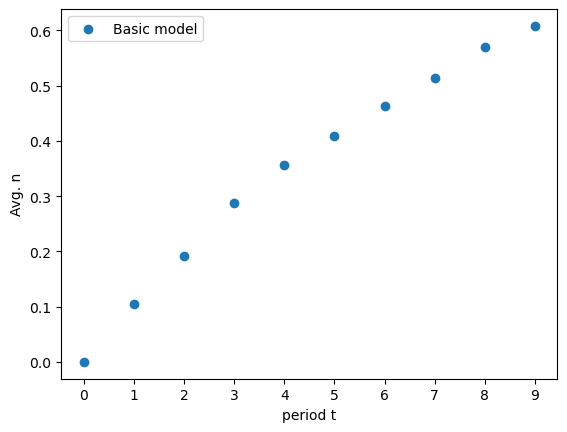

In [93]:
# Simulate and compare the model to the basic model
#spouse_model.simulate()

# Add legend to the plots
for var in ('c','a','h','n'):
    fig, ax = plt.subplots()
    ax.scatter(range(basic_model.par.simT),np.mean(getattr(basic_model.sim,var),axis=0),label='Basic model')
 #   ax.scatter(range(spouse_model.par.simT),np.mean(getattr(spouse_model.sim,var),axis=0),label='Spouse model')
    ax.legend()
    ax.set(xlabel='period t',ylabel=f'Avg. {var}',xticks=range(spouse_model.par.simT));


### Q3: Introduce childcare cost


In [84]:
# Initialize the model implementing the spouse 
childCost_model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'theta': 0.05}) # theta implements cost of children


In [85]:
# solve 
%time childCost_model.solve()

CPU times: total: 1min
Wall time: 1min 4s


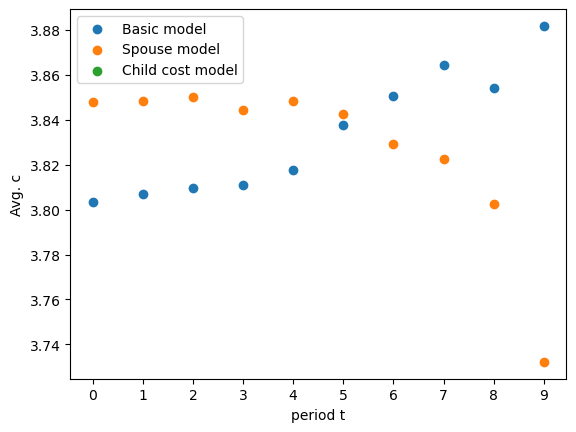

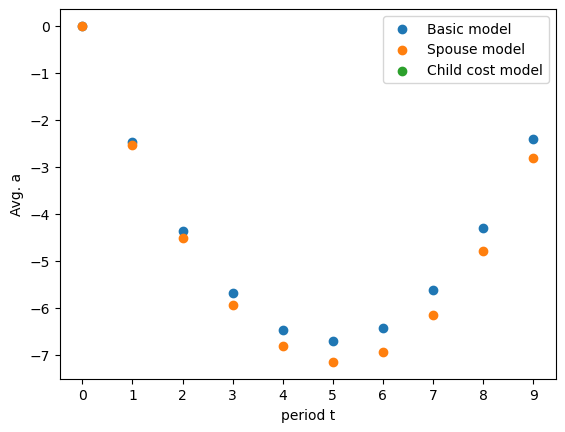

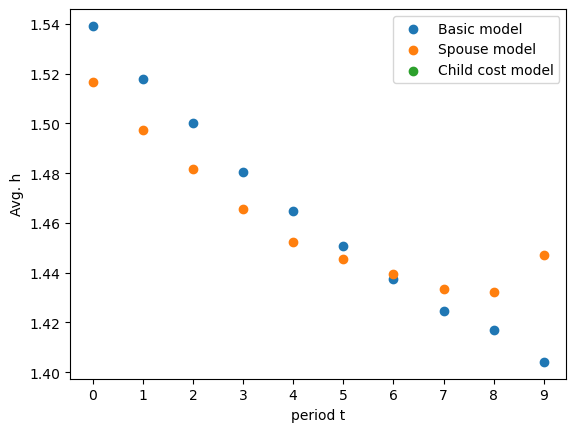

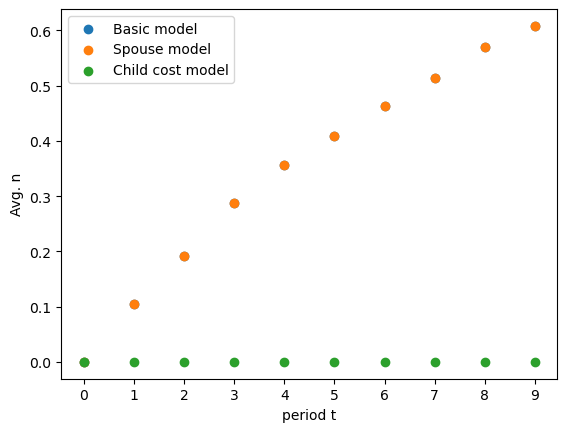

In [86]:
# Simulate and compare the model to the basic model
spouse_model.simulate()

# Add legend to the plots
for var in ('c','a','h','n'):
    fig, ax = plt.subplots()
    ax.scatter(range(basic_model.par.simT),np.mean(getattr(basic_model.sim,var),axis=0),label='Basic model')
    ax.scatter(range(spouse_model.par.simT),np.mean(getattr(spouse_model.sim,var),axis=0),label='Spouse model')
    ax.scatter(range(spouse_model.par.simT),np.mean(getattr(childCost_model.sim,var),axis=0),label='Child cost model')
    ax.legend()
    ax.set(xlabel='period t',ylabel=f'Avg. {var}',xticks=range(spouse_model.par.simT));

### Q5: Introduce random spouse which is required to give birth to a child

In [87]:
# Initialize the model
final_model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'zeta': 0.1}) # keep spouse income but set child cost to zero
